In [81]:
#%%writefile ../crypto_chaotic/lorenz_attractor.py
import numpy as np
from math import sin, cos, sqrt

class Lorenz_Attractor:
    def __init__(self,N = 3, tstep = 0.0001, ndrop = 15000, blocksize = 102400, pregen=True):
        self.rho=25
        self.sigma=10
        self.beta=1.5
        self.N = N
        self.tstep = tstep
        self.ndrop = ndrop
        self.pregen = pregen
        self.blocksize = blocksize
        if self.pregen:
            self.xt = self.pre_generate(self.blocksize)

    def deriv_send(self, xdot, x):
        xdot[0]=self.sigma * (x[1] - x[0])
        xdot[1]=x[0] * self.rho - x[1] - x[0] * x[2]
        xdot[2]=x[0] * x[1] - self.beta * x[2]
        return 0

    def deriv_receive(self, xdot, x, xp):
        xdot[0]=self.sigma * (x[1] - x[0])
        xdot[1]=xp * self.rho - x[1] - xp * x[2]
        xdot[2]=xp * x[1] - self.beta * x[2]
        return 0

    def rkm_send(self, h, x, N):
        xdot0 = np.zeros(N, dtype=np.float64)
        xdot1 = np.zeros(N, dtype=np.float64)
        xdot2 = np.zeros(N, dtype=np.float64)
        xdot3 = np.zeros(N, dtype=np.float64)
        g = np.zeros(N, dtype=np.float64)

        hh = h * 0.5
        self.deriv_send(xdot0, x)
        for i in range(N):
            g[i] = x[i] + hh * xdot0[i]

        self.deriv_send(xdot1, g)
        for i in range(N):
            g[i] = x[i] + hh * xdot1[i]

        self.deriv_send(xdot2, g)
        for i in range(N):
            g[i] = x[i] + h * xdot2[i]

        self.deriv_send(xdot3, g)
        for i in range(N):
            x[i] = x[i] + h * (xdot0[i] + 2.0 * 
                               (xdot1[i] + xdot2[i]) + 
                               xdot3[i]) / 6.0
        return 0

    def rkm_receive(self, h, x, xp, N):
        xdot0 = np.zeros(N, dtype=np.float64)
        xdot1 = np.zeros(N, dtype=np.float64)
        xdot2 = np.zeros(N, dtype=np.float64)
        xdot3 = np.zeros(N, dtype=np.float64)
        g = np.zeros(N, dtype=np.float64)

        hh = h * 0.5
        self.deriv_receive(xdot0, x, xp)
        for i in range(N):
            g[i] = x[i] + hh * xdot0[i]

        self.deriv_receive(xdot1, g, xp)
        for i in range(N):
            g[i] = x[i] + hh * xdot1[i]

        self.deriv_receive(xdot2, g, xp)
        for i in range(N):
            g[i] = x[i] + h * xdot2[i]

        self.deriv_receive(xdot3, g, xp)
        for i in range(N):
            x[i] = x[i] + h * (xdot0[i] + 2.0 * 
                               (xdot1[i] + xdot2[i]) + 
                               xdot3[i]) / 6.0

        return 0


    def pre_generate(self, nosdata):
        xt = np.zeros(nosdata, dtype=np.float64)

        xold = np.random.uniform(0, 1, size=self.N)    
        for i in range(self.ndrop):
            self.rkm_send(self.tstep, xold, self.N)

        for i in range(nosdata):
            self.rkm_send(self.tstep, xold, self.N)
            xt[i] = xold[0]
        return xt

    def chaos_encrypt(self, signal):
        nosdata = len(signal)
        encryptedx = np.zeros(nosdata, dtype=np.float64)

        if not self.pregen:
            xt = self.pre_generate(nosdata)
        else:
            xt = np.tile(self.xt, nosdata/self.blocksize)
            print len(xt), len(self.xt), nosdata, self.blocksize
            
        for i in range(nosdata):
            encryptedx[i] =  signal[i] + xt[i]

        return encryptedx, xt
        

    def chaos_decrypt(self, encryptedx):
        nosdata = len(encryptedx)

        xr = np.zeros(nosdata, dtype=np.float64)
        recovered = np.zeros(nosdata, dtype=np.float64)

        xold = np.random.uniform(0, 1, size=self.N)
        for i in range(self.ndrop):
            self.rkm_send(self.tstep, xold, self.N)

        for i in range(nosdata):
            self.rkm_receive(self.tstep, xold, encryptedx[i], self.N)
            xr[i] = xold[0]

        for i in range(nosdata):
            recovered[i] = encryptedx[i] - xr[i]

        return recovered, xr

In [82]:
#%%writefile ../crypto_chaotic/modulation.py
import numpy as np
from math import sin, cos, sqrt, pi
import matplotlib.pyplot as plt

def drawfft(signals, xlow=0, xhigh=0, ylow=0, yhigh=0):
    plt.figure(figsize=(15, 5))    
    if xlow < xhigh:
        plt.xlim([xlow,xhigh])
    if ylow < yhigh:
        plt.ylim([ylow,yhigh])
        
    for i in signals:
        sp = np.abs(np.fft.fft(i))
        freq = np.fft.fftfreq(len(sp), 1)

        Nindex = np.argmax(freq < 0)
        #freq1 = np.append(freq[Nindex:], freq[:Nindex])
        #sp1 = np.append(sp[Nindex:], sp[:Nindex])
        freq1 = freq[:Nindex]
        sp1 = sp[:Nindex]
        plt.plot(freq1, sp1)
    plt.show()
    
def plotamp(signals, xmin = 0, xmax = 0):    
    plt.figure(figsize=(15, 5))    
    x = range(len(signals[0]))
    if xmin < xmax:
        xi, xl = (xmin, xmax);
    else:
        xi, xl = (0, -1);
    print xi, xl
    for i in signals:
        plt.plot(x[xi: xl],i[xi: xl])
    plt.show()
    
class Modulation:
    def __init__(self, p = 100, sampling = 1, E=1):
        self.times = sampling
        self.p = p
        self.Scarrier  = np.array([E * sin((2*pi/self.p) * i)     for i in range(self.p*self.times)], dtype=np.float)
        self.NScarrier = np.array([E * sin((2*pi/self.p) * i+ pi) for i in range(self.p*self.times)], dtype=np.float)
        self.Ccarrier  = np.array([E * cos((2*pi/self.p) * i)     for i in range(self.p*self.times)], dtype=np.float)
        self.NCcarrier = np.array([E * cos((2*pi/self.p) * i+ pi) for i in range(self.p*self.times)], dtype=np.float)
    
    def qpsk_modulate(self, signal):
        nosdata = len(signal)
        modsig = np.array([], dtype=np.float)
        for i in range(nosdata):
            sig = int(signal[i])
            for k in range(32):
                if sig&0x01:
                    S = self.NScarrier
                else:
                    S = self.Scarrier

                if sig&0x02:
                    C = self.NCcarrier
                else:
                    C = self.Ccarrier
                modsig = np.append(modsig, S + C)
                sig = sig >> 2

        return modsig


    def qpsk_demodulate(self, modsig):
        nosdata = len(modsig)/(self.p*self.times)
        val = []
        rval = 0
        j = 0
        for i in range(nosdata):
            #Sconvolve = (np.convolve(Scarrier, modsig[i*p*times:(i+1)*p*times]))
            #Cconvolve = (np.convolve(Ccarrier, modsig[i*p*times:(i+1)*p*times]))
            #plotamp([modsig[i*p*times:(i+1)*p*times], Scarrier, Ccarrier])
            #plotamp([Scarrier + modsig[i*p*times:(i+1)*p*times], Ccarrier + modsig[i*p*times:(i+1)*p*times]])
            #if np.max(Sconvolve) + np.min(Sconvolve) > 0:
            if np.std(self.Scarrier + modsig[i*self.p*self.times:(i+1)*self.p*self.times]) < E:
                cval = 1
            else:
                cval = 0
            #if np.max(Cconvolve) + np.min(Cconvolve) > 0:
            if np.std(self.Ccarrier + modsig[i*self.p*self.times:(i+1)*self.p*self.times]) < E:
                sval = 1
            else:
                sval = 0
            dval = cval ^ sval <<1

            rval = rval ^ dval <<j
            #print cval, np.std(Scarrier + modsig[i*p*times:(i+1)*p*times])
            #print sval, np.std(Ccarrier + modsig[i*p*times:(i+1)*p*times])
            #plotamp([Scarrier + modsig[i*p*times:(i+1)*p*times], Ccarrier + modsig[i*p*times:(i+1)*p*times]])
            j += 2
            if j ==64:
                j = 0
                val.append(rval)
                rval = 0

        return np.array(val, dtype=np.uint64)


Populating the interactive namespace from numpy and matplotlib
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 67.9 µs
signal 3
CPU times: user 33.3 ms, sys: 6.67 ms, total: 40 ms
Wall time: 38.2 ms
modsig 384000
0 20000


`%matplotlib` prevents importing * from pylab and numpy


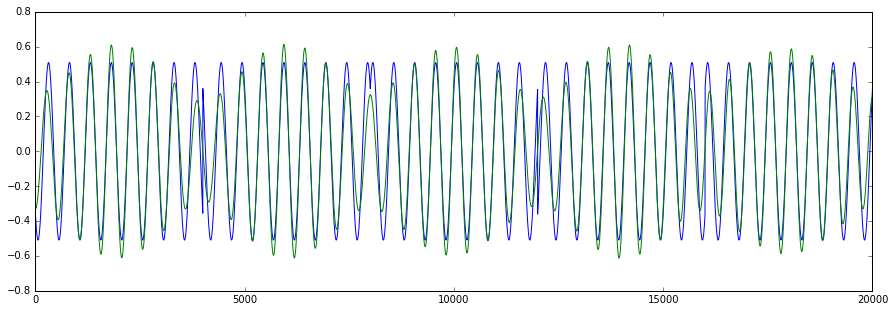

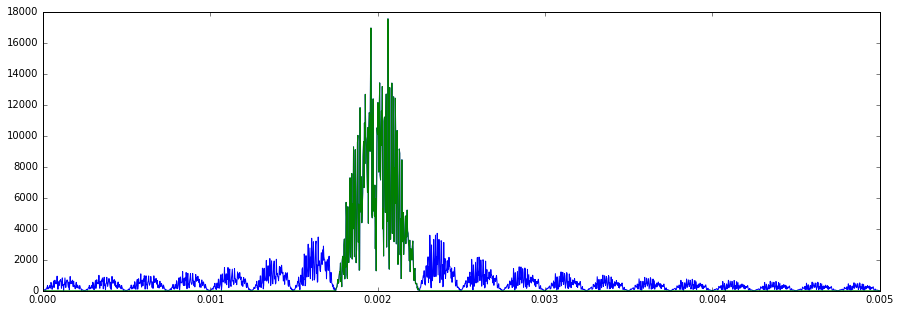

In [83]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
#from crypto_chaotic import lorenz_attractor
from scipy.fftpack import rfft, irfft, fftfreq

nosdata = 3
p = 500
E = 0.36
sampling = 8
filter_del = 0.0005

tstep = 0.001
ndrop = 1500 #15000
N = 4

modulation = Modulation(p = p, sampling = sampling, E = E)
#########################################
###     Random Signal Generation      ###
#########################################
%time signal = np.array([randrange(0, 2**64) for i in range(nosdata)], dtype=np.uint64)
#signalbypass = np.zeros(nosdata*32*p*sampling, dtype=np.uint64)
print "signal", len(signal)

#########################################
###          QPSK Modulation          ###
#########################################
%time modsig = modulation.qpsk_modulate(signal)
print "modsig", len(modsig)

#########################################
###         Frequency Domain          ###
#########################################
W = fftfreq(modsig.size, d=1)
f_signal = rfft(modsig)

#########################################
###              Filter               ###
#########################################
cut_f_signal = f_signal.copy()
#print (W<0.5/p)
cut_f_signal[(W>(2.0/p)+filter_del)] = 0
cut_f_signal[(W<(2.0/p)-filter_del)] = 0

#########################################
###            Time Domain            ###
#########################################
modsig_cut_signal = irfft(cut_f_signal)

#encryptedx, xt = lorenz_attractor.chaos_encrypt(signalbypass, N = N, tstep = tstep, ndrop = ndrop)  

plotamp([modsig, modsig_cut_signal], xmin = 0, xmax = 20000)

drawfft([modsig, modsig_cut_signal
                   ], xlow=0, xhigh=0.005, ylow=0, yhigh=0)

In [ ]:
%time lorenz_attractor = Lorenz_Attractor(N = N, tstep = tstep, ndrop = ndrop, blocksize = p*sampling*32*3, pregen=False)
#########################################
###           Chaos Encrypt           ###
#########################################

%time encryptedx, xt = lorenz_attractor.chaos_encrypt(modsig_cut_signal) 

CPU times: user 3.33 ms, sys: 0 ns, total: 3.33 ms
Wall time: 22.2 µs


In [116]:
#########################################
###           Chaos Decrypt           ###
#########################################
%time recovered, xr = lorenz_attractor.chaos_decrypt(encryptedx)

CPU times: user 14.5 s, sys: 137 ms, total: 14.7 s
Wall time: 14.5 s


In [117]:
#########################################
###         Frequency Domain          ###
#########################################
W = fftfreq(recovered.size, d=1)
f_signal = rfft(recovered)
#W = fftfreq(encryptedx.size, d=1)
#f_signal = rfft(encryptedx)

#########################################
###              Filter               ###
#########################################
cut_f_signal = f_signal.copy()
#print (W<0.5/p)
#cut_f_signal[(W<1/p)] = 0
#cut_f_signal[(W>0/p)] = 0
cut_f_signal[(W>(2.0/p)+filter_del)] = 0
cut_f_signal[(W<(2.0/p)-filter_del)] = 0
#print 0.9/p, 0.5/p

#########################################
###            Time Domain            ###
#########################################
recovered_cut_signal = irfft(cut_f_signal)

#########################################
###        QPSK Demodulation          ###
#########################################
%time dmodsig = modulation.qpsk_demodulate(recovered_cut_signal)

#########################################
###        Comparing Signals          ###
#########################################
if (signal == dmodsig).all():
    print 'matched'
else:
    print 'error'    
print signal == dmodsig

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 10.1 ms
error
[False False False]


0 100000


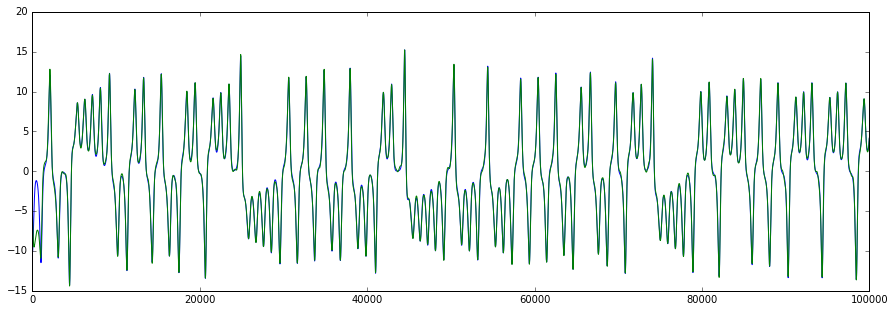

0 -1


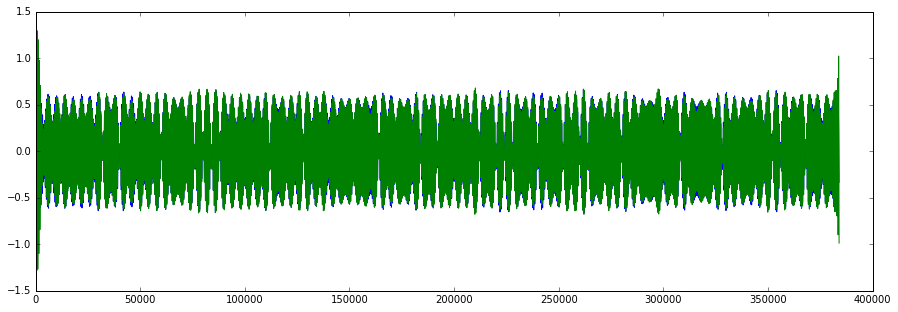

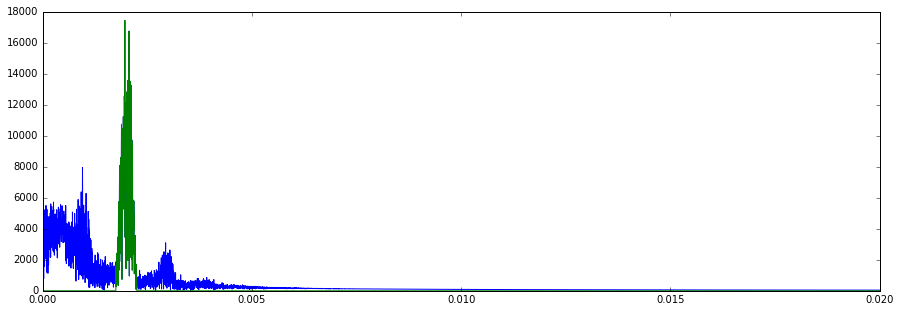

In [108]:
#########################################
###          Plot Signals             ###
#########################################
plotamp([xt, xr], xmin = 0, xmax = 100000)
plotamp([modsig_cut_signal, 
         #recovered, 
         recovered_cut_signal
        ], xmin = 0, xmax = 0)
drawfft([recovered, recovered_cut_signal], xlow=0, xhigh=0.02, ylow=0, yhigh=0)

In [109]:
if (signal[-10:] == dmodsig[-10:]).all():
    print 'matched'
else:
    print 'error'
print signal[-10:], dmodsig[-10:]
print signal[-10:] == dmodsig[-10:]

error
[ 1215155582569645191 10730273411335368567 11599501481601954316] [ 1215155582569645188 10730273411335368567  2376129444747178508]
[False  True False]


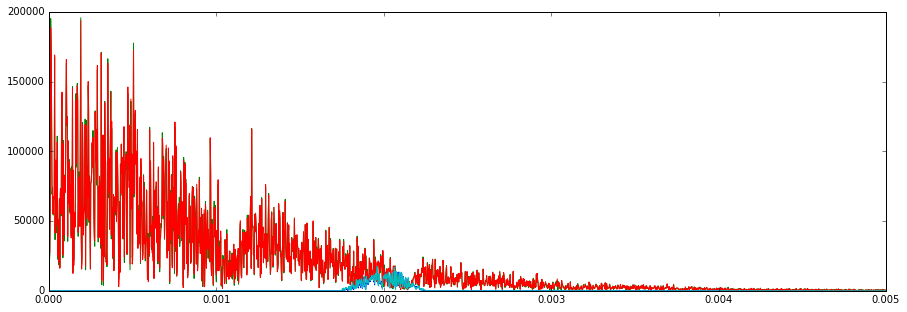

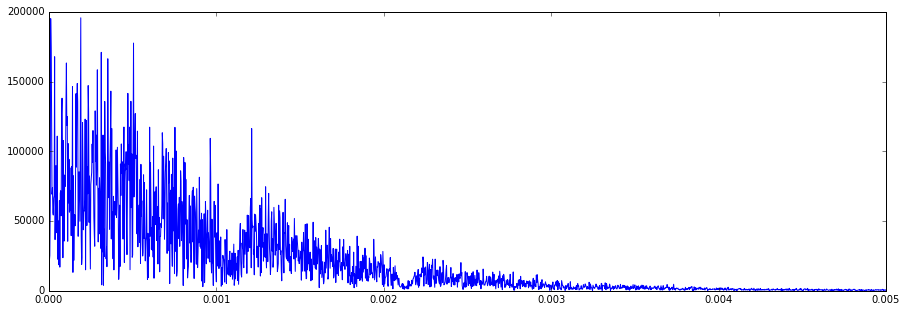

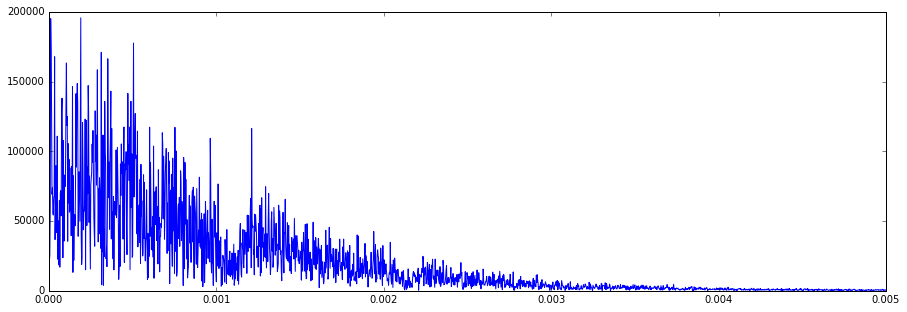

In [110]:
drawfft([modsig_cut_signal, xt, 
                    xr, recovered_cut_signal, 
                   ], xlow=0, xhigh=0.005, ylow=0, yhigh=0)

drawfft([xt,
                   ], xlow=0, xhigh=0.005, ylow=0, yhigh=0)

drawfft([encryptedx
                   ], xlow=0, xhigh=0.005, ylow=0, yhigh=0)

In [111]:
a = [2,3]
b = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
c = a * int(len(b)/len(a)) + a[:len(b)%len(a)]

In [64]:
print c, int(len(b)/len(a))

[2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2] 7
